# Solving a 2nd-order ODE IVP with a neural network

## Setup

In [1]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [2]:
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnode2ivp.py` module. The module allows the user to solve 2nd-order ordinary differential equation (ODE) initial value problems (IVPs) using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code differs slightly different from that used in the Lagaris paper.

## The algorithm

Any 2nd-order ODE can be written in the form:

\begin{equation}
G\left(x,y,\frac {dy}{dx},\frac {d^2y}{dx^2}\right) = 0
\end{equation}

The problem is to find a solution $y(x)$ to the ODE using a neural network, subject to the initial conditions:

\begin{equation}
y(0) = A
\end{equation}

\begin{equation}
\frac {dy}{dx}(0) = A'
\end{equation}

The network is trained using a set of *training points* $x_i$ ($1 \le i \le n$), defined on the domain of interest. The training points need not be evenly-spaced. Note that only the independent variable values $x_i$ of the training points are needed - the estimated value of the solution at those training points is obtained using a trial solution. Such an ODE can always be scaled and mapped onto the domain $[0,1]$, and this code assumes such mapping has already been performed. For a 2nd-order ODE IVP, the trial solution has the form:

\begin{equation}
y_t(x_i) = A(x_i) + P_1(x_i) A'(x_i) + P_2(x_i) N(x_i)
\end{equation}

The coefficient functions for this case are:

\begin{equation}
A(x_i) = A
\end{equation}

\begin{equation}
P_1(x_i) = x_i
\end{equation}

\begin{equation}
A'(x_i) = A'
\end{equation}

\begin{equation}
P_2(x_i) = x_i^2
\end{equation}

The trial solution can be written more compactly as:

\begin{equation}
y_{ti} = A + x_i A' + x_i^2 N_i
\end{equation}

where $y_{ti}=y_t(x_i,\vec p)$ is the value of the trial solution at the current training point $x_i$, and $N_i=N(x_i,\vec p)$ is the single-valued floating-point output from an unspecified neural network with parameters $\vec p$. Note that this trial solution satisfies the initial conditions by construction - at $x=0$, the second and third terms vanish, leaving $y_t(0)=A$. The derivative of $y_{ti}$ becomes $A'$ at $x=0$ in a similar fashion.

Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $x_i$, one at a time. For each input value $x_i$, the network output $N_i$ is computed, and used to compute the value of the trial solution $y_{ti}$. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The ODE definition (1) should vanish at convergence, and so an appropriate form for the error function is:

\begin{equation}
E = \sum_{j=1}^{n}G_i^2
\end{equation}

where $G_i$ is:

\begin{equation}
G_i = G\left(x_i,y_{ti},\frac {\partial y_{ti}}{\partial x_i},\frac {\partial^2 y_{ti}}{\partial x_i^2}\right)
\end{equation}

where $\frac {\partial y_{ti}}{\partial x_i}$ and $\frac {\partial^2 y_{ti}}{\partial x_u^2}$ are the first and second derivatives of the trial function with respect to $x$, evaluated at $x_i$. These derivatives are the current approximations of the analytical derivatives $\frac {dy}{dx}$ and $\frac {d^2y}{dx^2}$. Once this error function is computed, the weights and biases in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $y_t(x)$ is used as the solution to the original ODE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. A single input node is used to provide the training data. The input node is fully-connected to a set of $H$ hidden nodes. Each hidden node is connected to a single output node.

During each step of a training epoch, the input to the network, and thus the output of the single input node, is just the training point $x_i$. This single output is then sent to each of the $H$ hidden nodes. At each hidden node $k$, the input value $x_i$ is transformed by the equation:

\begin{equation}
z_{ik} = w_k x_i + u_k
\end{equation}

where $z_{ik}$ is the transformed input at hidden node $k$, $w_k$ is the weight at node $k$, and $u_k$ is the bias at node $k$. This transformed value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first several derivatives is provided below.

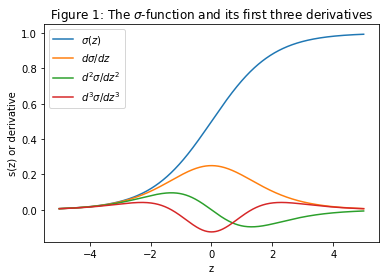

In [3]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

def d3sigma_dz3(z):
    return (
        6 * exp(-3 * z) / (1 + exp(-z))**4
        - 6 * exp(-2 * z) / (1 + exp(-z))**3
        + exp(-z) / (1 + exp(-z))**2
    )

z = np.linspace(-5, 5, 1001)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
d3s_dz3 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
    d3s_dz3[i] = d3sigma_dz3(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.plot(z,d3s_dz3, label = "$d^3\sigma/dz^3$");
plt.xlabel("z")
plt.ylabel("s(z) or derivative")
plt.title("Figure 1: The $\sigma$-function and its first three derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are summed by a linear transfer function to create the network output for the current value of $x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H} v_k \sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the signal from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $y_{ti}$ and its derivatives $\frac {\partial y_{ti}}{\partial x_i}$ and $\frac {\partial^2 y_{ti}}{\partial x_i^2}$ are computed, and then the value of the ODE $G_i$ is computed, and finally the error function $E$.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For a set of $H$ hidden nodes, we have a total of $N_p = 3H$ parameters in total: a weight and bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_k$) is updated using a scaled, simplified Newton's method:

\begin{equation}
p_{new} = p - \eta \frac {\partial E}{\partial p}
\end{equation}

where $\eta$ is the *learning rate* (usually $\eta < 1$). This simplified method (ignoring the usual 2nd derivative in the denominator of the correction term) is appropriate when the problem is scaled to the domain $[0,1]$. The learning rate is used to reduce the chance of solution instability due to large values of the correction term. The derivatives of $E$ are computed using the known form of the network and internal parameters.

This process of parameter updates is repeated until convergence is achieved (an error minimum is reached), or until the specified maximum number of training epochs have been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The partial derivative of $E$ with respect to any network parameter $p$ is given by:

\begin{equation}
\frac {\partial E}{\partial p} =
\frac {\partial}{\partial p} \sum_{i=1}^{n}G_i^2 =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

## Computing the derivatives of $G_i$

The partial derivative of $G_i$ with respect to any network parameter $p$ is computed using the chain rule:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial}{\partial p} G\left(x_i,y_{ti},\frac {\partial y_{ti}}{\partial x_i},\frac {\partial^2y_{ti}}{\partial x_i^2}\right) =
\frac {\partial G_i}{\partial x_i} \frac {\partial x_i}{\partial p} +
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}} \frac {\partial^2 y_{ti}}{\partial p \partial x_i} +
\frac {\partial G_i}{\partial \frac {\partial^2 y_{ti}}{\partial x_i^2}} \frac {\partial^3 y_{ti}}{\partial p \partial x_i^2}
\end{equation}

Since the training points $x_i$ are independent of the network parameters $\vec p$, this equation simplifies to:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}} \frac {\partial^2 y_{ti}}{\partial p \partial x_i} +
\frac {\partial G_i}{\partial \frac {\partial^2 y_{ti}}{\partial x_i^2}} \frac {\partial^3 y_{ti}}{\partial p \partial x_i^2}
\end{equation}

The analytical forms of $\frac {\partial G_i}{\partial y_{ti}}$, $\frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}}$, and $\frac {\partial G_i}{\partial \frac {\partial^2 y_{ti}}{\partial x_i^2}}$ are determined from the analytical form of the original ODE.

## Computing the derivatives of $y_{ti}$

The generic form of the first derivative of $y_{ti}$ is:

\begin{equation}
\frac {\partial y_{ti}}{\partial x_i} = A' + x_i^2 \frac {\partial N_i}{\partial x_i} + 2 x_i N_i
\end{equation}

The cross-partial of $y_{ti}$ is then:

\begin{equation}
\frac {\partial^2 y_{ti}}{\partial p \partial x_i} =
x_i^2 \frac {\partial^2 N_i}{\partial p \partial x_i} +
2 x_i \frac {\partial N_i}{\partial p}
\end{equation}

The generic form of the second derivative of $y_{ti}$ is:

\begin{equation}
\frac {\partial^2 y_{ti}}{\partial x_i^2} =
x_i^2 \frac {\partial^2 N_i}{\partial x_i^2} +
2 x_i \frac {\partial N_i}{\partial x_i} +
2 x_i \frac {\partial N_i}{\partial x_i} +
2 N_i =
x_i^2 \frac {\partial^2 N_i}{\partial x_i^2} +
4 x_i \frac {\partial N_i}{\partial x_i} +
2 N_i
\end{equation}

The cross-partial is then:

\begin{equation}
\frac {\partial^3 y_{ti}}{\partial p \partial x_i^2} =
x_i^2 \frac {\partial^3 N_i}{\partial p \partial x_i^2} +
4 x_i \frac {\partial^2 N_i}{\partial p \partial x_i} +
2 \frac {\partial N_i}{\partial p}
\end{equation}

## Computing the derivatives of $N_i$

The generic form of the first derivative of $N_i$ with respect to $x_i$ is:

\begin{equation}
\frac {\partial N_i}{\partial x_i} =
\frac {\partial}{\partial x_i} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k
\end{equation}

where the transfer function derivatives are defined by:

\begin{equation}
\sigma^{(n)} = \frac {\partial^n \sigma}{\partial z^n}
\end{equation}

For the parameter derivatives:

\begin{equation}
\frac {\partial N_i}{\partial p} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H \left ( v_k \frac {\partial \sigma_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right )
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_i} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \frac {\partial \sigma_{ik}^{(1)}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right )
\end{equation}

The generic form of the second derivative of $N_i$ with respect to $x_i$ is:

\begin{equation}
\frac {\partial^2 N_i}{\partial x_i^2} =
\frac {\partial}{\partial x_i} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k =
\sum_{k=1}^H v_k \sigma_{ik}^{(2)} w_k^2
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^3 N_i}{\partial p \partial x_i^2} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(2)} w_k^2 =
\sum_{k=1}^H \left(
v_k \sigma_{ik}^{(2)} 2 w_k \frac {\partial w_k}{\partial p} +
v_k \sigma_{ik}^{(3)} \frac {\partial z_{ik}}{\partial p} w_k^2 +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(2)} w_k^2
\right)
\end{equation}

## Computing the derivatives of $z_{ik}$

The derivatives of $z_{ik}$ with respect to the network parameter $p$ are parameter-specific:

\begin{equation}
\frac {\partial z_{il}}{\partial v_k} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial u_k} = \delta_{kl}
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial w_k} = x_i \delta_{kl}
\end{equation}

## Computing the derivatives of the parameters $\vec p$

At this lowest level, the parameter derivatives are simple in form:

\begin{equation}
\frac {\partial v_l}{\partial v_k} = \delta_{kl}, \frac {\partial v_l}{\partial u_k} = 0, \frac {\partial v_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial u_l}{\partial v_k} = 0, \frac {\partial u_l}{\partial u_k} = \delta_{kl}, \frac {\partial u_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial w_l}{\partial v_k} = 0, \frac {\partial w_l}{\partial u_k} = 0, \frac {\partial w_l}{\partial w_k} = \delta_{kl}
\end{equation}

Or, more succinctly:

\begin{equation}
\frac {\partial p_l}{\partial p_k} = \delta_{kl}
\end{equation}

# Walking through an example problem

We will now walk through a complete problem which will illustrate how to use the `nnode2ivp` code to solve a 2nd-order ODE IVP.

## Define the ODE to solve, and the initial conditions

Consider the simple 2nd-order ODE IVP, defined on the domain $[0, 1]$:

\begin{equation}
G\left(x,y,\frac {dy}{dx},\frac {d^2y}{dx^2}\right) = \frac {d^2y}{dx^2} - \frac {dy}{dx} + 2x - 1 = 0
\end{equation}

The analytical solution is:

\begin{equation}
y(x) = x^2 + x + 1
\end{equation}

The analytical solution and its derivatives are shown in the figure below.

In [4]:
def ya(x):
    return x**2 + x + 1

def dya_dx(x):
    return 2*x + 1

def d2ya_dx2(x):
    return 2

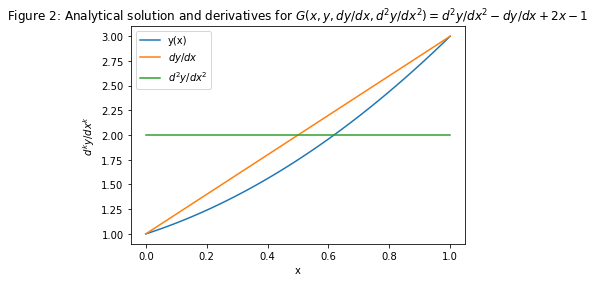

In [5]:
xmin = 0
xmax = 1
n = 100
x = np.linspace(xmin, xmax, n)
y = np.zeros(n)
dy_dx = np.zeros(n)
d2y_dx2 = np.zeros(n)
for i in range(n):
    y[i] = ya(x[i])
    dy_dx[i] = dya_dx(x[i])
    d2y_dx2[i] = d2ya_dx2(x[i])
plt.xlabel('x')
plt.ylabel('$d^ky/dx^k$')
plt.plot(x, y, label = 'y(x)')
plt.plot(x, dy_dx, label = "$dy/dx$")
plt.plot(x, d2y_dx2, label = "$d^2y/dx^2$")
plt.legend()
plt.title("Figure 2: Analytical solution and derivatives for $G(x,y,dy/dx,d^2y/dx^2)=d^2y/dx^2-dy/dx+2x-1$");

Define the differential equation itself, and its derivatives.

In [6]:
# Define the original differential equation:
def G(x, y, dy_dx, d2y_dx2):
    return d2y_dx2 - dy_dx + 2*x - 1

# Define the y-partial derivative of the differential equation.
def dG_dy(x, y, dy_dx, d2y_dx2):
    return 0

# Define the dy/dx-partial derivative of the differential equation.
def dG_dydx(x, y, dy_dx, d2y_dx2):
    return -1

# Define the d2y/dx2-partial derivative of the differential equation.
def dG_d2ydx2(x, y, dy_dx, d2y_dx2):
    return 1

The initial conditions are:

In [7]:
A = 1
Ap = 1

## Create the training data

For the purposes of this example, an evenly-spaced set of training points will be used to train the neural network.

In [8]:
nt = 10
xt = np.linspace(xmin, xmax, num = nt)

Note that repeated runs of the same ODE will usually result in slightly different solutions, due to the random number generator. To ensure repeatable results, seed the random number generator with a fixed value before each run.

## Train the model to solve the ODE

We can now train the network. The call below shows the minimum arguments required to call the `nnode2ivp()` function. All tunable parameters (learning rate `eta`, hidden layer size `H`, number of training epochs `max_epochs`) are given default values (`0.01`, `10`, `1000`, respectively). The training function returns the estimated values of $y$, $\frac {dy}{dx}$, and $\frac {d^2y}{dx^2}$ at the training points. When the `verbose` option is set to `True`, the function prints out the epoch number and current value of the mean-squared error of $G_i$.

In [9]:
from nnode2ivp import nnode2ivp
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2ivp(G, A, Ap, dG_dy, dG_dydx, dG_d2ydx2, xt, verbose = True)

0 3.1233327220117033
1 1.0583918522209046
2 0.9103333876828004
3 0.8294774329414829
4 0.7557034674279198
5 0.6878589533839008
6 0.6254984515030875
7 0.5682313786768904
8 0.5157030018499594
9 0.4675857616817987
10 0.423573492015778
11 0.38337766464395057
12 0.34672506852796803
13 0.31335646969593056
14 0.28302590983969883
15 0.25550039073761305
16 0.2305597625806378
17 0.20799668998486912
18 0.18761661231616858
19 0.16923764701649144
20 0.1526904077946055
21 0.13781772554581187
22 0.12447427025104091
23 0.11252607827268787
24 0.10184999267607298
25 0.09233302562614196
26 0.08387165264315609
27 0.07637104960413346
28 0.06974428580341471
29 0.06391149082768813
30 0.05879901959011461
31 0.05433864779130368
32 0.050466837273000796
33 0.0471241139989778
34 0.044254597210097814
35 0.041805704389827426
36 0.03972803380962591
37 0.03797539924667838
38 0.036504967417489105
39 0.03527743504438558
40 0.034257183129535684
41 0.033412359725677895
42 0.03271486388217444
43 0.03214022571252984
44 0.03

362 0.022383722133725283
363 0.022363778430641256
364 0.02234385346379739
365 0.022323947212719776
366 0.02230405965696415
367 0.02228419077611418
368 0.022264340549787577
369 0.022244508957629354
370 0.022224695979315034
371 0.02220490159455235
372 0.022185125783075906
373 0.022165368524652736
374 0.02214562979907914
375 0.022125909586180298
376 0.02210620786581217
377 0.02208652461786047
378 0.022066859822238456
379 0.022047213458892947
380 0.022027585507796137
381 0.022007975948952454
382 0.021988384762394775
383 0.021968811928184638
384 0.021949257426413633
385 0.021929721237202705
386 0.021910203340700755
387 0.021890703717087838
388 0.021871222346571306
389 0.021851759209388373
390 0.02183231428580341
391 0.021812887556111993
392 0.02179347900063788
393 0.02177408859973143
394 0.021754716333775063
395 0.02173536218317748
396 0.02171602612837653
397 0.021696708149838255
398 0.02167740822805707
399 0.021658126343557352
400 0.021638862476888916
401 0.021619616608632503
402 0.0216003

719 0.01631808635952493
720 0.016303723017296105
721 0.016289372643966724
722 0.016275035226840442
723 0.016260710753242088
724 0.01624639921050653
725 0.01623210058598952
726 0.016217814867055667
727 0.016203542041090604
728 0.016189282095491697
729 0.016175035017672586
730 0.016160800795063584
731 0.016146579415106756
732 0.016132370865263052
733 0.016118175133006184
734 0.016103992205825403
735 0.016089822071225345
736 0.01607566471672572
737 0.0160615201298611
738 0.016047388298181725
739 0.016033269209250463
740 0.016019162850648427
741 0.016005069209970395
742 0.015990988274823318
743 0.01597692003283355
744 0.01596286447163956
745 0.015948821578895135
746 0.015934791342269237
747 0.015920773749445467
748 0.015906768788120924
749 0.015892776446009154
750 0.01587879671083733
751 0.01586482957034876
752 0.015850875012299766
753 0.015836933024461312
754 0.01582300359461989
755 0.01580908671057688
756 0.015795182360146903
757 0.015781290531160355
758 0.015767411211460684
759 0.015753

Plot the results of this training run.

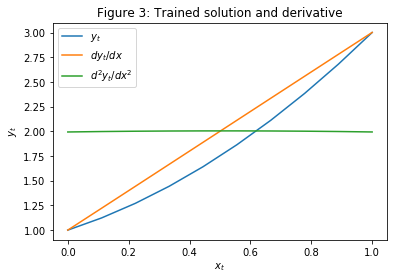

In [10]:
plt.plot(xt, yt, label = '$y_t$')
plt.plot(xt, dyt_dx, label = '$dy_t/dx$')
plt.plot(xt, d2yt_dx2, label = '$d^2y_t/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('$y_t$')
plt.legend()
plt.title("Figure 3: Trained solution and derivative");

Plot the error in the estimated solution and derivatives.

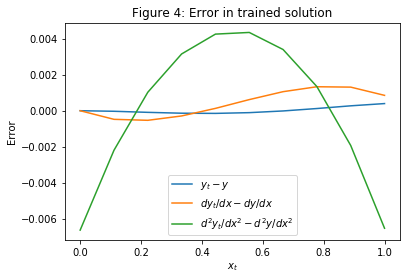

In [11]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
d2y_dx2 = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
    d2y_dx2[i] = d2ya_dx2(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 4: Error in trained solution");

Now try repeating the analysis with a larger number of hidden nodes, and plot the error.

In [12]:
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2ivp(G, A, Ap, dG_dy, dG_dydx, dG_d2ydx2, xt, nhid = 20)

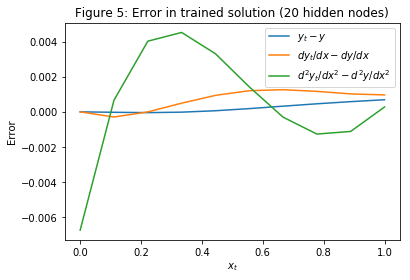

In [13]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
d2y_dx2 = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
    d2y_dx2[i] = d2ya_dx2(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 5: Error in trained solution (20 hidden nodes)");

Now try repeating the analysis with a slightly larger learning rate, and plot the error.

In [14]:
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2ivp(G, A, Ap, dG_dy, dG_dydx, dG_d2ydx2, xt, nhid = 20, eta = 0.02)

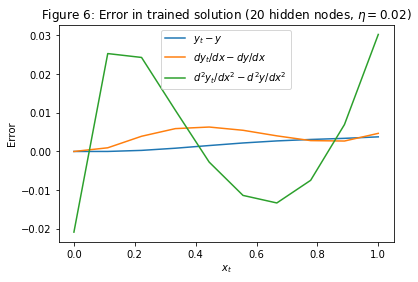

In [15]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
d2y_dx2 = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
    d2y_dx2[i] = d2ya_dx2(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 6: Error in trained solution (20 hidden nodes, $\eta=0.02$)");

Now try repeating the analysis with a larger number of training epochs, and plot the error.

In [16]:
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2ivp(G, A, Ap, dG_dy, dG_dydx, dG_d2ydx2, xt, nhid = 20, eta = 0.02, maxepochs = 2000)

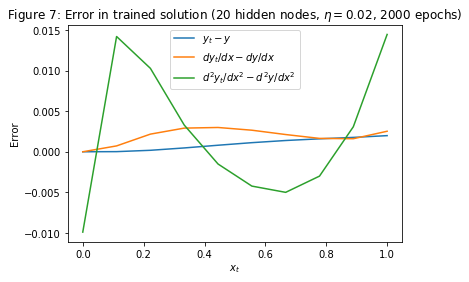

In [17]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
d2y_dx2 = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
    d2y_dx2[i] = d2ya_dx2(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 7: Error in trained solution (20 hidden nodes, $\eta=0.02$, 2000 epochs)");

## Using a ODE definition module

Rather than entering ODE definitions in this notebook, the required definitions can be entered in a separate Python module, and imported. For example, the previous code is also encapsulated in the file `ode01ivp.py`, and can be imported:

In [18]:
import ode01ivp

In [19]:
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2ivp(ode01ivp.Gf, ode01ivp.ic, ode01ivp.ic1, ode01ivp.dG_dyf, ode01ivp.dG_dydxf, ode01ivp.dG_d2ydx2f, xt)

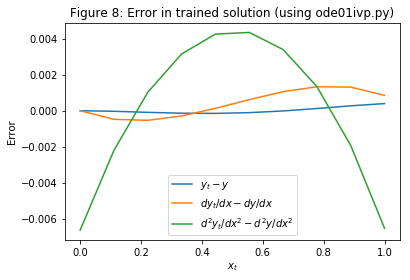

In [20]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
d2y_dx2 = np.zeros(nt)
for i in range(nt):
    y[i] = ode01ivp.yaf(xt[i])
    dy_dx[i] = ode01ivp.dya_dxf(xt[i])
    d2y_dx2[i] = ode01ivp.d2ya_dx2f(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 8: Error in trained solution (using ode01ivp.py)");